**first load the input.txt file to the colab it is presented here C:\Users\VARUN\Untitled Folder\char-rnn-keras-master\char-rnn-keras-master[MUSIC GENERATION CASE STUDY]\data
**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/My Drive/char-rnn-keras-master.zip (Unzipped Files)/char-rnn-keras-master'

/content/drive/My Drive/char-rnn-keras-master.zip (Unzipped Files)/char-rnn-keras-master


In [ ]:
!mkdir logs

In [ ]:
!mkdir data

In [ ]:
!mkdir model

In [ ]:
import os
import json
import argparse
import time
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding

DATA_DIR = './data'
LOG_DIR = './logs'

BATCH_SIZE = 16
SEQ_LENGTH = 64

MODEL_DIR = './model'

def save_weights(epoch, model):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def load_weights(epoch, model):
    model.load_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def build_model(batch_size, seq_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_len)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=True, stateful=True))
        model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    return model


class TrainLogger(object):
    def __init__(self, file):
        self.file = os.path.join(LOG_DIR, file)
        self.epochs = 0
        with open(self.file, 'w') as f:
            f.write('epoch,loss,acc\n')

    def add_entry(self, loss, acc):
        self.epochs += 1
        s = '{},{},{}\n'.format(self.epochs, loss, acc)
        with open(self.file, 'a') as f:
            f.write(s)

def read_batches(T, vocab_size):
    length = T.shape[0]; #129,665
    batch_chars = int(length / BATCH_SIZE); # 8,104

    for start in range(0, batch_chars - SEQ_LENGTH, SEQ_LENGTH): # (0, 8040, 64)
        X = np.zeros((BATCH_SIZE, SEQ_LENGTH)) # 16X64
        Y = np.zeros((BATCH_SIZE, SEQ_LENGTH, vocab_size)) # 16X64X86
        for batch_idx in range(0, BATCH_SIZE): # (0,16)
            for i in range(0, SEQ_LENGTH): #(0,64)
                X[batch_idx, i] = T[batch_chars * batch_idx + start + i] # 
                Y[batch_idx, i, T[batch_chars * batch_idx + start + i + 1]] = 1
        yield X, Y

def train(text, epochs=100, save_freq=10):
    # character to index and vice-versa mappings
    char_to_idx = { ch: i for (i, ch) in enumerate(sorted(list(set(text)))) }
    print("Number of unique characters: " + str(len(char_to_idx))) #86

    with open(os.path.join(DATA_DIR, 'char_to_idx.json'), 'w') as f:
        json.dump(char_to_idx, f)

    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    #model_architecture
    model = build_model(BATCH_SIZE, SEQ_LENGTH, vocab_size)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    #Train data generation
    T = np.asarray([char_to_idx[c] for c in text], dtype=np.int32) #convert complete text into numerical indices

    print("Length of text:" + str(T.size)) #129,665

    steps_per_epoch = (len(text) / BATCH_SIZE - 1) / SEQ_LENGTH  

    log = TrainLogger('training_log.csv')
    x1 = time.time()
    for epoch in range(epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        x12 = time.time()
        losses, accs = [], []

        for i, (X, Y) in enumerate(read_batches(T, vocab_size)):
            
            loss, acc = model.train_on_batch(X, Y)
            #print('Batch {}: loss = {}, acc = {}'.format(i + 1, loss, acc))
            losses.append(loss)
            accs.append(acc)

        log.add_entry(np.average(losses), np.average(accs))
        y12 = time.time()
        print(' epoch {} loss = {} acc = {}'.format(epoch+1,np.average(losses),np.average(accs)))
        print('time taken to compute one epoch is ',y12-x12)
        if (epoch + 1) % save_freq == 0:
            save_weights(epoch + 1, model)
            print('Saved checkpoint to', 'weights.{}.h5'.format(epoch + 1))
    y1 = time.time()
    print('total time taken for this training is {}'.format(y1-x1))


if __name__ == '__main__':
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)

    train(open('/content/drive/MyDrive/char-rnn-keras-master.zip (Unzipped Files)/char-rnn-keras-master/data/input.txt').read())


Number of unique characters: 86
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (16, 64, 512)             44032     
_________________________________________________________________
lstm_10 (LSTM)               (16, 64, 256)             787456    
_________________________________________________________________
dropout_10 (Dropout)         (16, 64, 256)             0         
_________________________________________________________________
lstm_11 (LSTM)               (16, 64, 256)             525312    
_________________________________________________________________
dropout_11 (Dropout)         (16, 64, 256)             0         
_________________________________________________________________
lstm_12 (LSTM)               (16, 64, 256)             525312    
_________________________________________________________________
dropout_12 (Dropout)  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 epoch 1 loss = 3.1544575691223145 acc = 0.1777111291885376
time taken to compute one epoch is  31.174921989440918

Epoch 2/100
 epoch 2 loss = 2.178602457046509 acc = 0.3836418092250824
time taken to compute one epoch is  28.669554948806763

Epoch 3/100
 epoch 3 loss = 1.780774474143982 acc = 0.4846695065498352
time taken to compute one epoch is  28.67562508583069

Epoch 4/100
 epoch 4 loss = 1.6173232793807983 acc = 0.524003267288208
time taken to compute one epoch is  28.7133629322052

Epoch 5/100
 epoch 5 loss = 1.5027230978012085 acc = 0.5447978377342224
time taken to compute one epoch is  28.553953886032104

Epoch 6/100
 epoch 6 loss = 1.4062188863754272 acc = 0.5593532919883728
time taken to compute one epoch is  28.625120878219604

Epoch 7/100
 epoch 7 loss = 1.3461246490478516 acc = 0.57211834192276
time taken to compute one epoch is  28.43920087814331

Epoch 8/100
 epoch 8 loss = 1.294150948524475 acc = 0.5844261646270752
time taken to compute one epoch is  28.53044104576111


In [ ]:
!pwd

/content/drive/My Drive/char-rnn-keras-master.zip (Unzipped Files)/char-rnn-keras-master


In [ ]:
import pandas as pd
f = pd.read_csv('./logs/training_log.csv')
f

,epoch,loss,acc


In [ ]:
import argparse
import os
import json

import numpy as np



from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding

DATA_DIR = './data'
MODEL_DIR = './model'

def load_weights(epoch, model):
    model.load_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))


def build_sample_model(vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(1, 1)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=True, stateful=True))
        model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    return model

def sample(epoch=100, header='', num_chars=2048):
    with open(os.path.join(DATA_DIR, 'char_to_idx.json')) as f:
        char_to_idx = json.load(f)
    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    model = build_sample_model(vocab_size)
    load_weights(epoch, model)
    model.save(os.path.join(MODEL_DIR, 'model.{}.h5'.format(epoch)))

    sampled = [char_to_idx[c] for c in header]
    print(sampled)
    

    for i in range(num_chars):
        batch = np.zeros((1, 1))
        if sampled:
            batch[0, 0] = sampled[-1]
        else:
            batch[0, 0] = np.random.randint(vocab_size)
        result = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(vocab_size), p=result)
        sampled.append(sample)

    return ''.join(idx_to_char[c] for c in sampled)

if __name__ == '__main__':
    print(sample())


[]
GA "G"G2:|
K:A
|:M: /8
"D"d3/2f/2g f2a|"G"gfg bag|"D"afd "A7"Adc|"D"d3 d2||


X: 296
T:Sralling Jigg
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:D
A|"D"d2d dcd|"G"B2d "D"A3|"G"Bcd "A"efg|"D"fdd "A7"d2c|
"D"dcd "A"e2A|"G"dBG "A"A2B|"D"Adc "G"BAG|
"D"FAA dAA|"G"BAB "D"def|"Em"gfe "Bm"fdB|
"E7"BAB dcB|"E7"BAB Bcd|"Em"cde "A7"ecA|d3 -d2:|


X: 293
T:Scollyc
% Nottingham Music Database
S:FTB 2/42, via EF
Y:AB
M:6/8
K:A
P:A
E|"A"A3 A2c|"A"e2d cde|"D"f2d fgf|"A"e3 "E7"dcd|
"A"e2A A2e|"D"f2e faf|"D""A"e3 "A/c+"ABc|"Bm"d2B "E7"c2d|"A"ecA "A7"Ace|\
"D"f2d "B7"a2f|
"A"e3 c3|"D"d2f a2f|"G"g2f "E7"e2d|"A"c2A Ace|
"D"f2f fgf|"E7"e^de efg|"A"a2A ABc|"E7"B3 -B2:|


X: 291
T:Comon Lan's Fancy
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:Em
c|:"Em"BGE F2E|"Em"BGE "D"FGA|"Em"B3 -A2A|"G"G3 "C"gfe|"G"dcB "D7"AGF|"G"G3 G3:|


X: 102
T:Fram Apon Him
% Nottingham Music Database
S:Mike Richardson 16.12.89, via Phil Rowe
M:6/8
K:D
a3 |"D"f2f f3|"D"a2f "G"g2f|"A"eae cBA|"D"d2f "A"ec

In [ ]:
import seaborn
import matplotlib.pyplot as plt
f = pd.read_csv('./logs/training_log.csv')
f.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


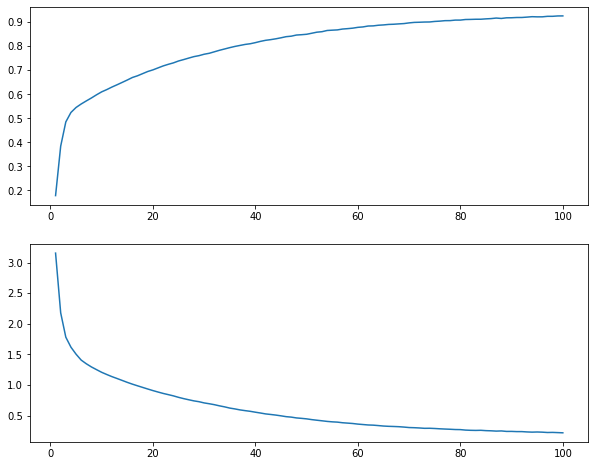

In [ ]:
plt.figure(figsize=(10,8)) 
fig1 = plt.subplot(2,1,1)
fig2 = plt.subplot(2,1,2)
fig1.plot(f['epoch'],f['acc'])
fig2.plot(f['epoch'],f['loss'])

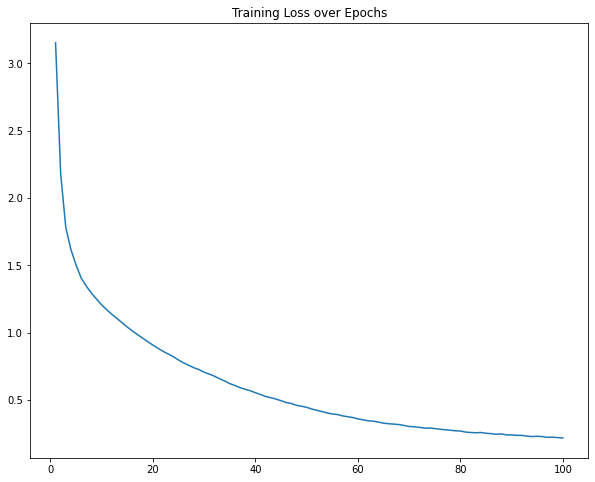

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(f['epoch'], f['loss'])
plt.title('Training Loss over Epochs')
plt.show()